In [ ]:
from __future__ import division, print_function

import xmlreader as xml
import utils as ut
import numpy as np

import gensim.models.word2vec
import itertools
from collections import Counter
from nltk.tokenize import word_tokenize

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import collections
import numpy as np
import matplotlib.pyplot as plt
import operator
import os
%matplotlib inline

In [ ]:
train_docs= xml.readXML("intertass-PE-train-tagged.xml")

In [3]:
test_docs= xml.readXML("intertass-PE-test.xml")

In [4]:
corpus = []
for doc in train_docs + test_docs:
    corpus.append(doc.content)

In [5]:
tokenized_train_docs = []
for doc in train_docs:
    tokenized_train_docs.append(ut.tokenize(doc.content, doc.polarity))
    
tokenized_test_docs = []
for doc in test_docs:
    tokenized_test_docs.append(ut.tokenize(doc.content, doc.polarity))

In [6]:
train_tweets = []
train_labels = []
for tweet in tokenized_train_docs:
    train_tweets.append(tweet['words'])
    train_labels.append(tweet['class'])

train_tweets = np.array(train_tweets)
train_labels = np.array(train_labels)

# train_tweets, test_tweets, train_labels, test_labels = ut.crossValidation2(tweets, labels, 3)

In [7]:
test_tweets = []
test_labels = []
for tweet in tokenized_test_docs:
    test_tweets.append(tweet['words'])
    test_labels.append(tweet['class'])

test_tweets = np.array(test_tweets)
test_labels = np.array(test_labels)

In [8]:
def CountFrequency(sentences): 
  
    # Creating an empty dictionary  
    freq = {} 
    for s in sentence:
        for item in my_list: 
            if (item in freq): 
                freq[item] += 1
            else: 
                freq[item] = 1
                
  
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 
        
    return freq

In [9]:
def map_word_frequency(list_of_words):
    return Counter(itertools.chain(*list_of_words))

In [10]:
word_counts = map_word_frequency(np.concatenate([train_tweets, test_tweets]))

In [11]:
def gensim_load_vec(path="SBW-vectors-300-min5.bin"):
    #use gensim_emb.wv.index2word if used this way to load vectors
    #gensim_emb = gensim.models.word2vec.Word2Vec.load(path)
    gensim_emb =  gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
    vocab = gensim_emb.index2word
    vec = gensim_emb.syn0
    shape = gensim_emb.syn0.shape
    return gensim_emb, vec, shape, vocab

In [12]:
gensim_emb, vec, shape, vocab = gensim_load_vec()

D:\opt\Anaconda3\envs\SI\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  
D:\opt\Anaconda3\envs\SI\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


In [13]:
# sent_emb = sentence2vec(sent_list,300,gensim_emb)

## Estimate Vocabulary Size

In [14]:
counter = CountVectorizer(strip_accents="unicode")

In [15]:
X = counter.fit_transform(corpus)
print(X.shape)

(2428, 8286)


Text(0.5, 0, 'words')

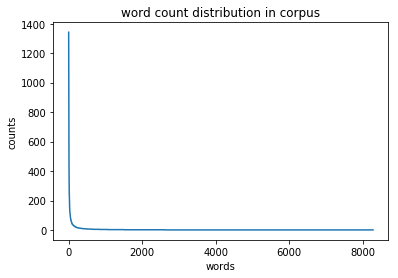

In [16]:
counts = np.sum(X, axis=0).tolist()
counts = sorted(counts[0], reverse=True)
plt.plot(np.arange(len(counts)), counts)
plt.title("word count distribution in corpus")
plt.ylabel("counts")
plt.xlabel("words")

## Compute Baseline Embedding (BoW)

<a href="https://www.codecogs.com/eqnedit.php?latex=v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;v_w" target="_blank"><img src="https://latex.codecogs.com/gif.latex?v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;v_w" title="v_s = \frac{1}{\left \| S \right \|} \sum_{w \in S} v_w" /></a>

In [17]:
VOCAB_SIZE = 8000
# VOCAB_SIZE = X.shape[1]
counter = CountVectorizer(strip_accents="unicode",
                          max_features=VOCAB_SIZE)
caption_texts = corpus
Xc = counter.fit_transform(caption_texts).todense().astype("float")
print(Xc.shape)

(2428, 8000)


In [18]:
sent_lens = np.sum(Xc, axis=1).astype("float")
sent_lens[sent_lens == 0] = 1e-14
print(sent_lens.shape)

(2428, 1)


In [19]:
E = np.zeros((VOCAB_SIZE, 300))
for word in list(counter.vocabulary_.keys()):
    try:
        i = counter.vocabulary_[word]
        E[i] = gensim_emb[word]
    except KeyError:
        pass
print(E.shape)

(8000, 300)


In [20]:
Xb = np.divide(np.dot(Xc, E), sent_lens)
print(Xb.shape)

(2428, 300)


In [21]:
Xtrain, Xtest = Xb[0:len(train_docs)], Xb[-len(test_docs):]
ytrain, ytest = np.array(train_labels), np.array(test_labels)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(1000, 300) (1000,) (1428, 300) (1428,)


In [22]:
def cross_val(Xtrain, ytrain, clf):
    best_clf = None
    best_score = 0.0
    num_folds = 0
    cv_scores = []
    kfold = KFold(n_splits=10)
    for train, val in kfold.split(Xtrain):
        Xctrain, Xctest, yctrain, yctest = Xtrain[train], Xtrain[val], ytrain[train], ytrain[val]
        clf.fit(Xctrain, yctrain)
        score = clf.score(Xctest, yctest)
        if score > best_score:
            best_score = score
            best_clf = clf
        print("fold {:d}, score: {:.3f}".format(num_folds, score))
        cv_scores.append(score)
        num_folds += 1
    return best_clf, cv_scores

def test_eval(Xtest, ytest, clf):
    print("===")
    print("Test set results")
    ytest_ = clf.predict(Xtest)
    accuracy = accuracy_score(ytest, ytest_)
    print("Accuracy: {:.3f}".format(accuracy))
    print("---")
    print("Confusion Matrix")
    cm = confusion_matrix(ytest, ytest_)
    print(cm)
    print("---")
    print("Classification Report")
    cr = classification_report(ytest, ytest_)
    print(cr)

In [23]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
best_clf, scores_nb = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.610
fold 1, score: 0.690
fold 2, score: 0.590
fold 3, score: 0.570
fold 4, score: 0.660
fold 5, score: 0.730
fold 6, score: 0.560
fold 7, score: 0.640
fold 8, score: 0.530
fold 9, score: 0.600
===
Test set results
Accuracy: 0.653
---
Confusion Matrix
[[932 496]
 [  0   0]]
---
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      1428
           1       0.00      0.00      0.00         0

   micro avg       0.65      0.65      0.65      1428
   macro avg       0.50      0.33      0.39      1428
weighted avg       1.00      0.65      0.79      1428



D:\opt\Anaconda3\envs\SI\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [24]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.590
fold 1, score: 0.800
fold 2, score: 0.590
fold 3, score: 0.630
fold 4, score: 0.700
fold 5, score: 0.650
fold 6, score: 0.600
fold 7, score: 0.760
fold 8, score: 0.630
fold 9, score: 0.630
===
Test set results
Accuracy: 0.681
---
Confusion Matrix
[[973 455]
 [  0   0]]
---
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.68      0.81      1428
           1       0.00      0.00      0.00         0

   micro avg       0.68      0.68      0.68      1428
   macro avg       0.50      0.34      0.41      1428
weighted avg       1.00      0.68      0.81      1428



D:\opt\Anaconda3\envs\SI\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
